In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/Users/ericsun/Documents/GitHub


 # Exploratory Analysis
 We'll be exploring the CIS enrollment data to find patterns and see what
 information we can resolve. Danny wrote a handy data structure for the data
 that we're going to try here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from extract import Data
import re
import seaborn as sns

FILENAME = "data/CIS_enrollment.csv"
ENCODING = "iso-8859-1"

data = Data(FILENAME)
raw  = pd.read_csv(FILENAME, encoding=ENCODING)


 # Pre-processing
 One challenge we're going to run into is that the course data makes no
 distinction among lectures and discussion blocks. We can see three cases:

 * Lecture with discussion - we should remove the discussion
 * Lecture without discussion - this is fine
 * Discussion with no lecture - we need to retain these records

 This presents a pretty significant challenge to a filtering procedure that
 we'd like to develop.

 It would be really useful to be able to identify core classes for a major. One
 way to do that would be to identify what percentage of students who declare a
 major have taken that class. Let's see how that works out.

In [3]:
def get_students_in_major(major):
    return dict(filter(lambda s: s[1].major == major, data.students.items()))

def get_prop(course, major=""):
    if major == "":
        students = data.students
    else:
        students = filter(lambda s: s[1].major == major, data.students.items())

    return len(data.courses[course].students) / len(dict(students))

course = "CS1110"
major = "Computer Science"
p = get_prop(course, major)
print(f"{p:.2%} of {major} majors take {course}")


72.79% of Computer Science majors take CS1110


In [10]:
pattern = re.compile(r"^INFO\d{4}$")
info_courses = list(filter(lambda c: re.match(pattern,c), data.courses.keys()))

courses = [1110, 2110, 2112, 2800, 3110, 3410, 3420, 4410, 4820, 4620, 4780]
courses = [f"INFO{n}" for n in courses]
major = "Information Science"

y = [get_prop(course, major) for course in courses]

df = pd.DataFrame({"Course": info_courses, "Proportion":y})
df = df.sort_values("Proportion", ascending=False).reset_index(drop=True)
df['Core'] = df.Course.map(color);
sub_df = df.loc[0:30]

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.barh(sub_df.Course, sub_df.Proportion, color=sub_df.Core)
ax.invert_yaxis()
plt.title("Proportion of IS Majors who take IS Classes")
fig.show()

KeyError: 'INFO1110'

<BarContainer object of 12 artists>

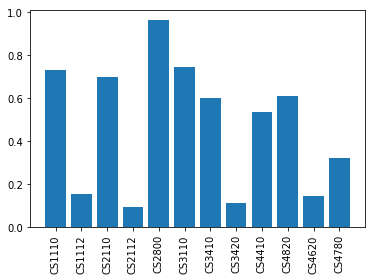

In [4]:
courses = [1110, 1112, 2110, 2112, 2800, 3110, 3410, 3420, 4410, 4820, 4620, 4780]
courses = [f"CS{n}" for n in courses]
major = "Computer Science"

y = [get_prop(course, major) for course in courses]
plt.xticks(range(len(courses)), courses, rotation='vertical')
plt.bar(courses, y)


 Now let's try that with *every* CS class and see what the distribution is.

/Users/ericsun/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


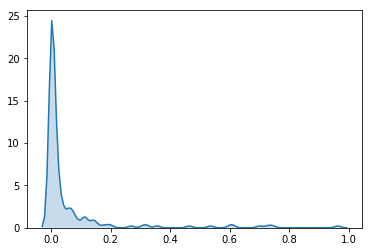

In [5]:
pattern = re.compile(r"^CS\d{4}$")
cs_courses = list(filter(lambda c: re.match(pattern, c), data.courses.keys()))

y = [get_prop(course, major) for course in cs_courses]
sns.kdeplot(y, shade=True)


 Let's see what some of those top classes are.

/Users/ericsun/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


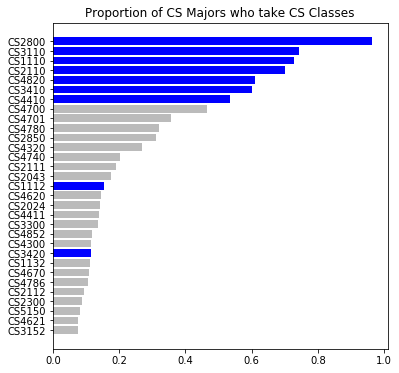

In [6]:
cs_core = [1110, 1112, 2110, 2800, 2802, 3110, 3410, 3420, 4410, 4820]
cs_core = list(map(lambda n: f"CS{n}", cs_core))

color = lambda course: 'blue' if course in cs_core else '#bbbbbb'

df = pd.DataFrame({"Course": cs_courses, "Proportion":y})
df = df.sort_values("Proportion", ascending=False).reset_index(drop=True)
df['Core'] = df.Course.map(color)
sub_df = df.loc[0:30]

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.barh(sub_df.Course, sub_df.Proportion, color=sub_df.Core)
ax.invert_yaxis()
plt.title("Proportion of CS Majors who take CS Classes")
fig.show()


 We can immediately see that the 5 core courses plus the two introductory
 courses have the highest attendance from CS majors. But we can also see some
 other looming challenges.

 ## Honors Classes
 A number of important CS courses have honors options, including 1110, 2110,
 and now 2802, which are some of the most popular courses. If we could reliably
 aggregate these together, it would probably move those courses further up.
 More importantly though, we need to think about how to visualize pathways
 where an honors class might be an equally viable option.

 ## Complements
 This is less of an issue, as it's essentially a specification of the central
 problem we're trying to solve with this project. CS 3420 (embedded systems)
 can substitute for 3410 in the CS core, but it's a lot less popular and
 doesn't seem to have the trappings of a "core class". This is only really an
 issue to the extent that we want to literally show users what the core major
 courses based on the data we have access to.

 I'm going to take a quick detour here to demo the

 ## Courses of Study API
 This is a bit rocky, since virtually the only useful endpoint the API provides
 is the `search/classes` endpoint, which requires you to enter all the
 parameters of your course (except the number of the course, which isn't an
 allowed search term) and then find the course you want in the results. This is
 really annoying but if you abstract it away it's useful enough that I can get
 over it. Here's a demo.

In [7]:
import urllib.request
import json
recent_semesters = ['FA19']#, 'SP19']

def get_info(course):
    dept = course[:-4]
    num  = course[-4:]
    for semester in recent_semesters:
        url = f"https://classes.cornell.edu/api/2.0/search/classes.json?roster={semester}&subject={dept}"
        response = urllib.request.urlopen(url)
        data = json.load(response)

        if data['status'] != 'success':
            continue

        for course in data['data']['classes']:
            if course['catalogNbr'] == num:
                return course

    else:
        raise ValueError("Course number does not exist")

    #return class_dat

d = get_info("CS4780")
print(json.dumps(d, indent=2))


{
  "strm": 2741,
  "crseId": 358592,
  "crseOfferNbr": 1,
  "subject": "CS",
  "catalogNbr": "4780",
  "titleShort": "Machine Learning Intell Sys",
  "titleLong": "Machine Learning for Intelligent Systems",
  "enrollGroups": [
    {
      "classSections": [
        {
          "ssrComponent": "LEC",
          "ssrComponentLong": "Lecture",
          "section": "001",
          "classNbr": 12632,
          "meetings": [
            {
              "classMtgNbr": 1,
              "timeStart": "02:55PM",
              "timeEnd": "04:10PM",
              "startDt": "08/29/2019",
              "endDt": "12/10/2019",
              "instructors": [
                {
                  "instrAssignSeq": 4,
                  "netid": "nh386",
                  "firstName": "Nika",
                  "middleName": "",
                  "lastName": "Haghtalab"
                },
                {
                  "instrAssignSeq": 1,
                  "netid": "tj36",
                  "firstName

 Nice! This gives us way more information than we could ever possibly want.
 Some useful keys to this json file:

 - `titleLong`: The full name of the course
 - `titleShort`: An abbreviation of the course title
 - `description`: The full text course description
 - `catalogPrereqCoreq`: Text describing prerequisites. Still in a string
   that's hard to parse but nevertheless present.
 - `catalogWhenOffered`: Pretty useful if you're trying to segment a pathway
   into specific semesters.
 - `enrollGroups/n/unitsMinimum`: The number of credits the course counts for

 There's not really any actual documentation, much less models for this API so
 most of this is inferred. In any case, it's a good way to get some basic
 course info so we don't have to send anyone away from the site. I don't know
 what response times look like (i.e. whether we can or should load this
 dynamically) but I can see this being useful in a hover or a preview box.

In [8]:
from IPython.display import display, Markdown
from ipywidgets import widgets

text = widgets.Text()
display(text)


def show(course):
    course = course.value

    d = get_info(course)

    txt = [
        f"# {course}: {d['titleLong']} ({d['enrollGroups'][0]['unitsMinimum']})\n\n",
        f"{d['description']}\n\n"
        f"**Offered in the** {d['catalogWhenOffered']}"
    ]

    display(Markdown("".join(txt)))


text.on_submit(show)


Text(value='')